# Imports

In [1]:
# USE pip install lightly==1.1.17!!!!!!!!!!!!

In [2]:
%matplotlib inline

In [3]:
from tqdm.notebook import tqdm

In [4]:
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

import torchmetrics

import lightly

import matplotlib.pyplot as plt
import numpy as np

import copy

/home/shatz/miniconda3/envs/morebetter3/lib/python3.9/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.18. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.20
  warnings.warn(Warning(warning))


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# device = torch.device("cpu")

device(type='cuda')

# DATA

In [6]:
# data params
num_workers = 6
batch_size = 1

In [7]:
path_to_train = './data/cifar10_lightly/train/'
path_to_test = './data/cifar10_lightly/test/'

In [8]:
# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
])

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)

In [9]:
val_dataloader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# MOCO data

In [10]:
# ive made this file because the standard BaseCollateFunction from lightly
# only supports returning x0 and x1 augmentations for some image x. I also want x returned
# to send to the classifier and to add the reconstruction gradient to
from myCollate import BetterSimCLRCollateFunction

In [11]:
# MoCo v2 uses SimCLR augmentations, additionally, disable blur
# collate_fn = lightly.data.SimCLRCollateFunction(
#     input_size=32,
#     gaussian_blur=0.,
# )

collate_fn = BetterSimCLRCollateFunction(
    input_size=32,
    gaussian_blur=0.
)

In [12]:
custom_tfm = torchvision.transforms.Compose([transforms.ToPILImage(), collate_fn.transform,])
custom_tfm;

# Classifier

In [13]:
# model params
n_classes=10
pretrained_model = "./saved_models/resnet_80/epoch=73-val_loss=0.64-val_acc=0.80.ckpt"

In [14]:
from plr18 import plr18

In [15]:
model = plr18().load_from_checkpoint(pretrained_model);

In [16]:
model.to(device);
model.eval();

# Defense model

In [17]:
memory_bank_size = 4096

In [18]:
# Load my cutom model specifically frozen as fuck for reverse attacks
from moco_model_reverse import ReverseMocoModel

In [19]:
moco = ReverseMocoModel(memory_bank_size)
moco = moco.load_from_checkpoint('./saved_models/resnet_moco/epoch=2989-train_loss_ssl=1.37.ckpt', memory_bank_size=memory_bank_size)
moco.eval();

In [20]:
# Holy shit make sure everything is frozen 10 times i dont care

for p in moco.resnet_moco.parameters():  # reset requires_grad
    p.requires_grad = False

moco.freeze()

for p in moco.parameters():
    if p.requires_grad:
        print('BAD')

# Experiment

In [21]:
seed = 1
batch_limit = 1500

In [22]:
epsilons = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
            0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.023, 0.026, 0.029, 0.034,
            .05, .1, .15, .2, 0.3]

epsilons = [0, 0.001, 0.002, 0.007, 0.008,
            0.01, 0.012, 0.016, 0.018, 0.02, 0.023, 0.026, 0.029, 0.034,
            .05] # , .1, .15, .2, 0.3]

In [23]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [24]:
def reverse_fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    fixed_image = image - epsilon*sign_data_grad
    fixed_image = torch.clamp(fixed_image, 0, 1)
    return fixed_image

In [25]:
def test2( classifier, defender, test_loader, epsilon, batch_limit=100):

    # Accuracy counter
    correct = 0
    fixed_correct = 0
    adv_examples = []
    og_contrastive_loss_avg = 0
    perturbed_contrastive_loss_avg = 0
    grad_perturbed_contrastive_loss_avg = 0
        
    classifier = classifier.to(device)
    
    #     defender = defender.load_from_checkpoint('./saved_models/resnet_moco/epoch=2989-train_loss_ssl=1.37.ckpt')
    defender = defender.to(device)

    # Loop over all examples in test set
    for sample in enumerate(tqdm(val_dataloader)):

        # Send the data and label to the device
        # data, target = data.to(device), target.to(device)
        (idx, (data, target, filename)) = sample
        
        # Set requires_grad attribute of tensor. Important for Attack
        data = data.to(device)
        data.requires_grad = True
        target = target.to(device)

        # Forward pass the data through the model
        output = classifier(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        classifier.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Re-classify the perturbed image
        output = classifier(perturbed_data)
        
                
        ### Semi supervised part ###
        # get data pairs
        x0 = custom_tfm(data.squeeze(0))
        x1 = custom_tfm(data.squeeze(0))
        x0_perturbed = custom_tfm(perturbed_data.squeeze(0))
        x1_perturbed = custom_tfm(perturbed_data.squeeze(0))
        
        # send them to gpu
        x0 = x0.to(device)
        x1 = x1.to(device)
        x0_perturbed = x0_perturbed.to(device)
        x1_perturbed = x1_perturbed.to(device)
        
        ### safety check was here ###
        # x0_c = x0.detach().clone()
        # x1_c = x1.detach().clone()
        # x0p_c = x0_perturbed.detach().clone()
        # x1p_c = x1_perturbed.detach().clone()
        
        # contrastive loss
        og_contrastive_loss = defender.contrastive_loss_nograd(x0.unsqueeze(0), x1.unsqueeze(0))
        # perturbed_contrastive_loss = defender.contrastive_loss_nograd(x0_perturbed.unsqueeze(0), x1_perturbed.unsqueeze(0))
        # x0g, x1g, grad_perturbed_contrastive_loss = ext_contrastive_loss(x0_perturbed.unsqueeze(0), x1_perturbed.unsqueeze(0))
        # x0g, x1g, grad_perturbed_contrastive_loss = out_contrastive_loss(defender, x0_perturbed.unsqueeze(0), x1_perturbed.unsqueeze(0))
        x0g, x1g, grad_perturbed_contrastive_loss = defender.contrastive_loss(x0_perturbed.unsqueeze(0), x1_perturbed.unsqueeze(0))
        
        # now repair the perturbed image using its grad
        fixed_data = reverse_fgsm_attack(perturbed_data, epsilon, x0g)
        
        # reclassify fixed image
        fixed_output = classifier(fixed_data)

        
        og_contrastive_loss_avg += og_contrastive_loss
        #perturbed_contrastive_loss_avg += perturbed_contrastive_loss
        grad_perturbed_contrastive_loss_avg += grad_perturbed_contrastive_loss
        

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        fixed_final_pred = fixed_output.max(1, keepdim=True)[1]
        if fixed_final_pred.item() == target.item():
            fixed_correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        if batch_limit:
            if idx > batch_limit:
                break

    # Calculate final accuracy for this epsilon
    div = min(float(len(test_loader)), float(batch_limit))
    final_acc = correct/div
    fixed_final_acc = fixed_correct/div
    og_contrastive_loss_avg = og_contrastive_loss_avg / div
    # perturbed_contrastive_loss_avg = perturbed_contrastive_loss_avg / div
    grad_perturbed_contrastive_loss_avg = grad_perturbed_contrastive_loss_avg / div
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}\t Repaired Accuracy = {}\n og_cont_loss = {} | pert_cont_loss = NA | grad_pert_cont_loss = {}"\
          .format(epsilon, correct, div, final_acc, fixed_final_acc, og_contrastive_loss_avg, grad_perturbed_contrastive_loss_avg))

    # Return the accuracy and an adversarial example
    return final_acc, fixed_final_acc, adv_examples, og_contrastive_loss_avg, grad_perturbed_contrastive_loss_avg

In [26]:
accuracies = []
fixed_accuracies = []
examples = []
og_contrastive_losses = []
# perturbed_contrastive_losses = []
grad_perturbed_contrastive_losses = []

# Run test for each epsilon
for eps in tqdm(epsilons):
    acc, fixed_acc, ex, og_contrastive_loss, grad_perturbed_contrastive_loss =\
    test2(model, moco, val_dataloader, eps, batch_limit=batch_limit)
    accuracies.append(acc)
    examples.append(ex)
    og_contrastive_losses.append(og_contrastive_loss)
    # perturbed_contrastive_losses.append(perturbed_contrastive_loss)
    grad_perturbed_contrastive_losses.append(grad_perturbed_contrastive_loss)
    fixed_accuracies.append(fixed_acc)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/shatz/miniconda3/envs/morebetter3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epsilon: 0	Test Accuracy = 1298 / 1500.0 = 0.8653333333333333	 Repaired Accuracy = 0.8653333333333333
 og_cont_loss = 1.0540943145751953 | pert_cont_loss = NA | grad_pert_cont_loss = 1.0941330194473267


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.001	Test Accuracy = 1242 / 1500.0 = 0.828	 Repaired Accuracy = 0.828
 og_cont_loss = 1.0819090604782104 | pert_cont_loss = NA | grad_pert_cont_loss = 1.1067510843276978


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.002	Test Accuracy = 1179 / 1500.0 = 0.786	 Repaired Accuracy = 0.7873333333333333
 og_cont_loss = 1.079615831375122 | pert_cont_loss = NA | grad_pert_cont_loss = 1.137017846107483


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.007	Test Accuracy = 887 / 1500.0 = 0.5913333333333334	 Repaired Accuracy = 0.5926666666666667
 og_cont_loss = 1.095431923866272 | pert_cont_loss = NA | grad_pert_cont_loss = 1.1338571310043335


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.008	Test Accuracy = 830 / 1500.0 = 0.5533333333333333	 Repaired Accuracy = 0.56
 og_cont_loss = 1.174555778503418 | pert_cont_loss = NA | grad_pert_cont_loss = 1.1702345609664917


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.01	Test Accuracy = 758 / 1500.0 = 0.5053333333333333	 Repaired Accuracy = 0.508
 og_cont_loss = 1.0464682579040527 | pert_cont_loss = NA | grad_pert_cont_loss = 1.2223432064056396


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.012	Test Accuracy = 679 / 1500.0 = 0.45266666666666666	 Repaired Accuracy = 0.45466666666666666
 og_cont_loss = 1.0936548709869385 | pert_cont_loss = NA | grad_pert_cont_loss = 1.2795484066009521


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.016	Test Accuracy = 556 / 1500.0 = 0.37066666666666664	 Repaired Accuracy = 0.38133333333333336
 og_cont_loss = 1.0561811923980713 | pert_cont_loss = NA | grad_pert_cont_loss = 1.360438585281372


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.018	Test Accuracy = 513 / 1500.0 = 0.342	 Repaired Accuracy = 0.3446666666666667
 og_cont_loss = 1.1243988275527954 | pert_cont_loss = NA | grad_pert_cont_loss = 1.457044243812561


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.02	Test Accuracy = 468 / 1500.0 = 0.312	 Repaired Accuracy = 0.32466666666666666
 og_cont_loss = 1.0762083530426025 | pert_cont_loss = NA | grad_pert_cont_loss = 1.404934287071228


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.023	Test Accuracy = 417 / 1500.0 = 0.278	 Repaired Accuracy = 0.2826666666666667
 og_cont_loss = 1.0480421781539917 | pert_cont_loss = NA | grad_pert_cont_loss = 1.4426878690719604


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.026	Test Accuracy = 385 / 1500.0 = 0.25666666666666665	 Repaired Accuracy = 0.262
 og_cont_loss = 1.117343783378601 | pert_cont_loss = NA | grad_pert_cont_loss = 1.5518380403518677


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.029	Test Accuracy = 350 / 1500.0 = 0.23333333333333334	 Repaired Accuracy = 0.23733333333333334
 og_cont_loss = 1.0873899459838867 | pert_cont_loss = NA | grad_pert_cont_loss = 1.54146146774292


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.034	Test Accuracy = 303 / 1500.0 = 0.202	 Repaired Accuracy = 0.21666666666666667
 og_cont_loss = 1.085315465927124 | pert_cont_loss = NA | grad_pert_cont_loss = 1.5498952865600586


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.05	Test Accuracy = 229 / 1500.0 = 0.15266666666666667	 Repaired Accuracy = 0.154
 og_cont_loss = 1.0867146253585815 | pert_cont_loss = NA | grad_pert_cont_loss = 1.6361373662948608


# 📈 Results 📉

In [27]:
og_contrastive_losses = [t.cpu().detach().numpy() for t in og_contrastive_losses]
# perturbed_contrastive_losses = [t.cpu().detach().numpy() for t in perturbed_contrastive_losses]
grad_perturbed_contrastive_losses = [t.cpu().detach().numpy() for t in grad_perturbed_contrastive_losses]

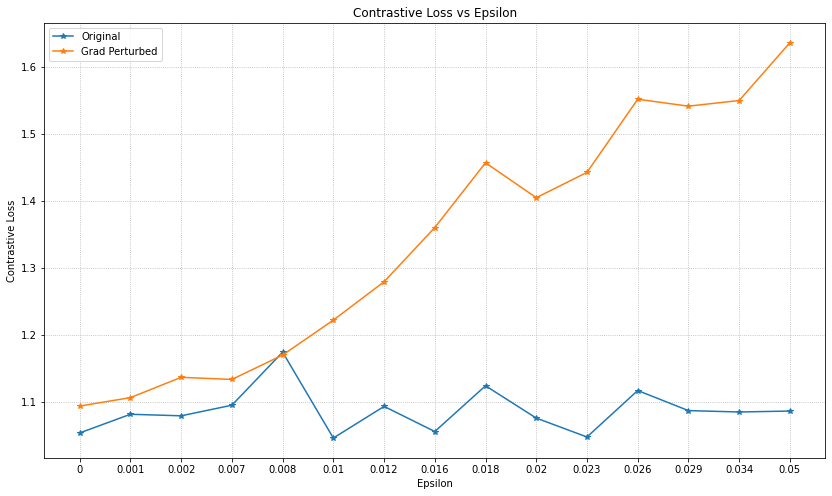

In [28]:
# equally distanced plots
plt.figure(figsize=(14,8))

plt.plot(range(len(epsilons)), og_contrastive_losses, "*-", label='Original')
#plt.plot(range(len(epsilons)), perturbed_contrastive_losses, "*-", label='Perturbed')
plt.plot(range(len(epsilons)), grad_perturbed_contrastive_losses, "*-", label='Grad Perturbed')

plt.xticks(range(len(epsilons)), epsilons)
plt.title("Contrastive Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.grid(linestyle=':')
plt.show()

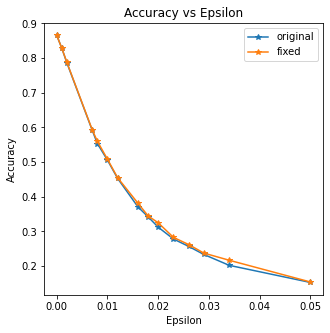

In [29]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-", label="original")
plt.plot(epsilons, fixed_accuracies, "*-", label="fixed")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

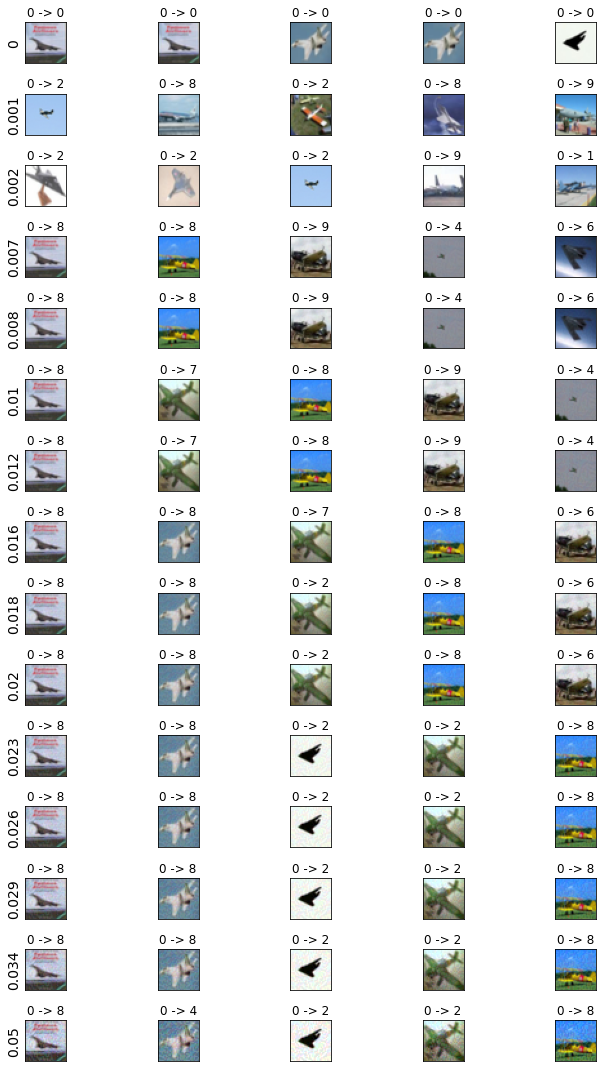

In [30]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(10, 15))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("{}".format(epsilons[i]), fontsize=14) # eps 
        orig,adv,ex = examples[i][j]
        ex = np.moveaxis(ex, 0, -1)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# NOTES

1. Some hacks I made in the lightly library to make this work: 

    Line 100 in `lightly/loss/nxt_ent_loss.py`
    - `super(NTXentLoss, self).forward(out1, update=out0.requires_grad and update_memory_bank)`
    - This should not be breaking, but I should update library later and make this a pull request. Reason: sometimes you want to see the loss for a data sample without updating the memory bank. Such as in my research.

    Line 106 in `lightly/models/moco.py`
    - `# self._momentum_update(self.m)`
    - commented this out to not update momentum. Consider contributing this as well. This is breaking, so I cant train until I fix this.
    
    
2. Hacks have now been moved into classes I built and overrode their code. Best to integrate these changes in pull requests anyway. Get me sum resume pts :)